In [1]:
%matplotlib inline

import os

import cv2 as cv
import json
import matplotlib.pyplot as plt
from PIL import Image as PIL_Image
import torch
from tqdm import tqdm as loadingbar

from dataset import Dataset, LabelManager, label_extractor
from filtration import FilterManager, FilterBlackAndWhite, FilterHSV, FilterFocusMeasure
from unified_image_reader import Image as UIR_Image

import util

from testing.histolab.tile import Tile
from testing.histolab.scorer import NucleiScorer, CellularityScorer

In [2]:
#data_path = "/workspaces/dev-container/testing/data/whole_slide_images/val/0"
#measure = NucleiScorer(preprocess = lambda region : Tile(PIL_Image.fromarray(region), coords=(0,0)))
#dataset = None
#try:
#    dataset = Dataset(
#        data = data_path,
#        labels = LabelManager(path=data_path, label_extraction=label_extractor.LabelExtractorNoLabels()),
#        filtration = measure,
#        filtration_cache="filtration_cache_histolab.h5",
#        filtration_preprocess={"n_regions":100},
#        filtration_preprocess_loadingbars=True
#    )
#except Exception as e:
#    print("deleting dataset")
#    del dataset
#    raise e

In [22]:
data_path = "/workspaces/dev-container/testing/data/whole_slide_images/train"
dataset = Dataset(
    data = data_path,
    labels = LabelManager(path=data_path, label_extraction=label_extractor.LabelExtractorNoLabels()),
    filtration = FilterManager([
        FilterBlackAndWhite(),
        FilterHSV(),
        FilterFocusMeasure()
    ])
)
print(type(dataset))
print(dataset._filepaths)

<class 'dataset.dataset.Dataset'>
['/workspaces/dev-container/testing/data/whole_slide_images/train/0/84440T_004.tif', '/workspaces/dev-container/testing/data/whole_slide_images/train/1/84429T_003.tif']


In [23]:
scoring_data = None
scoring_data_filepath = "output/scoring_data.json"
with util.open_file(scoring_data_filepath) as f:
    scoring_data = json.load(f)
print(scoring_data)

{'/workspaces/dev-container/testing/data/whole_slide_images/train/0/84440T_004.tif': [[0.04365461170295601, 182]], '/workspaces/dev-container/testing/data/whole_slide_images/train/1/84429T_003.tif': [[0.06391989230772681, 1829]]}


In [53]:
class TilesDataset(torch.utils.data.Dataset):
    def __init__(self, underlying_dataset, scoring_data_filepath):
        if not isinstance(underlying_dataset, Dataset): raise TypeError(type(underlying_dataset))
        self.underlying_dataset = underlying_dataset
        self.scoring_data_filepath = scoring_data_filepath
        # load in scoring data
        self.scoring_data = None
        with util.open_file(self.scoring_data_filepath) as f:
            self.scoring_data = json.load(f)
        self._filepaths = list(self.scoring_data.keys())
        # preprocess from fields and verify that scoring data files are in dataset
        self._passing_region_counts = {}
        for filepath in self.scoring_data.keys(): # for each filepath in the tilesdataset
            if filepath not in self.underlying_dataset._region_counts: # if filepath isn't in underlying dataset
                raise Exception(f"filepath not in dataset: {filepath}")
            self._passing_region_counts[filepath] = len(self.scoring_data[filepath]) # otherwise record length
        self._len = sum(self._passing_region_counts.values())
    def __len__(self):
        return self._len
    def __getitem__(self, index):
        if not 0 <= index < len(self):
            raise IndexError(index, len(self))
        region_filename, region_index = None, None
        for filename, region_count in self._passing_region_counts.items():
            if index >= region_count:
                index -= region_count
            else:
                region_filename, region_index = filename, index
                break
        region_index = self.scoring_data[region_filename][region_index][1]
        region = self.underlying_dataset.get_region(region_filename, region_index)
        return region
    def get_region_labels_as_list(self):
        region_labels = []
        for filepath in self._filepaths:
            label = self.underlying_dataset.get_label(filepath)
            regions_in_filepath = self._passing_region_counts[filepath]
            region_labels.extend([label] * regions_in_filepath)
        return region_labels
    def get_label_distribution(self):
        label_distribution = {}
        for label in self.get_region_labels_as_list():
            if label not in label_distribution:
                label_distribution[label] = 0
            label_distribution[label] += 1
        return label_distribution
tds = TilesDataset(dataset, scoring_data_filepath)

(512, 512, 3)


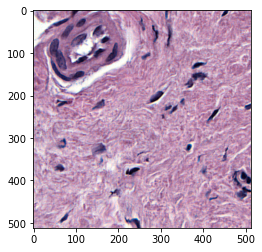

In [54]:
region = tds[0]
print(region.shape)
plt.imshow(region)